In [1]:
import os
from pathlib import Path

import pandas as pd 
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from nilearn import plotting
import nibabel as nb

from scipy.stats import zscore

import statsmodels.formula.api as smf
from statsmodels.stats import weightstats
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

In [2]:
full_sample = pd.read_csv("full_sample_stats.tsv", sep="\t", index_col=0).drop("sub-10298")
copes_task = pd.read_csv("FSL_task/copes.tsv", sep="\t", index_col=0)
copes_hrv = pd.read_csv("FSL_hrv/copes.tsv", sep="\t", index_col=0)
hrv = pd.read_csv("mri_sample_hrv.tsv", sep="\t", index_col=0)

# Handle outliers in HRV
for var in hrv.columns:
    m = hrv[var].mean()
    median = hrv[var].median()
    sd = hrv[var].std()
    out = abs((hrv[var] - m) / sd) > 3
    hrv[var][out] = median

## Behavioural data - CDS subscale  x metacognition in patients

In [3]:
full_sample[["CDS_State"]][full_sample["group"]=="control"].describe()

,CDS_State
count,21.000000
mean,120.761905
std,192.503741
min,2.000000
25%,25.000000
50%,54.000000
75%,114.000000
max,877.000000


In [4]:
full_sample[["CDS_State", "TotDuration"]][full_sample["group"]=="patient"].describe()

,CDS_State,TotDuration
count,40.00000,40.000000
mean,304.75000,28.000000
std,298.81988,21.178121
min,0.00000,0.000000
25%,59.00000,14.500000
50%,197.00000,25.500000
75%,492.25000,41.000000
max,1144.00000,89.000000


CDS_State: t(56.35690933747776) = -2.910204228254159, p = 0.005163192288285354


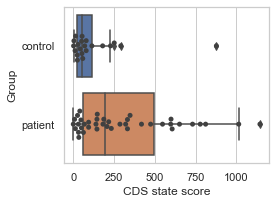

In [5]:
tstat, pval, df = weightstats.ttest_ind(full_sample["CDS_State"][full_sample["group"]=="control"], 
                                        full_sample["CDS_State"][full_sample["group"]=="patient"],
                                        usevar="unequal")
print(f"CDS_State: t({df}) = {tstat}, p = {pval}")
plot_data = full_sample[["group", "CDS_State"]]
plot_data.columns = ["Group", "CDS state score"]

sns.set_context("paper")
sns.set(style="whitegrid")
plt.figure(figsize=(4,3))
sns.boxplot(y="Group", x="CDS state score",data=plot_data,)
sns.swarmplot(y="Group", x="CDS state score", data=plot_data, color=".25")
plt.tight_layout()
plt.savefig("figures/cds_ttest.png", dpi=300)

### CDS subscales vs metacognition

In [6]:
fep_stat = ["AlienSurroundTot", "AnomSubRecTot", "EmoNumTot", "AnomBodyExpTot", "HeartAware", "NoteAware"]
fep_stat = full_sample[fep_stat][full_sample["group"] == "patient"]
fep_stat["HeartNoteAware_bias"] = np.log(full_sample["HeartAware"] / full_sample["NoteAware"])
fep_stat["HeartNoteAcc_bias"] = np.log(full_sample["HeartAcc"] / full_sample["NoteAcc"])

In [7]:
mod = smf.ols(formula=f'HeartAware ~ AlienSurroundTot + AnomSubRecTot + EmoNumTot + AnomBodyExpTot', 
              data=fep_stat.apply(zscore))
res = mod.fit()
print(res.summary())
reject, p_corrected, _, alphaBonf = multipletests(res.pvalues, method='holm-sidak', is_sorted=False)
corrected_p = pd.DataFrame(res.pvalues.values, index=res.pvalues.index, columns=["uncorrected"])
corrected_p["corrected"] = p_corrected
corrected_p

                            OLS Regression Results                            
Dep. Variable:             HeartAware   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     3.499
Date:                Wed, 06 May 2020   Prob (F-statistic):             0.0167
Time:                        16:28:55   Log-Likelihood:                -50.030
No. Observations:                  40   AIC:                             110.1
Df Residuals:                      35   BIC:                             118.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -6.87e-16      0.143  

,uncorrected,corrected
Intercept,1.000000,1.000000
AlienSurroundTot,0.008933,0.043874
AnomSubRecTot,0.991472,0.999927
EmoNumTot,0.638616,0.952804
AnomBodyExpTot,0.224747,0.638779


In [8]:
mod = smf.ols(formula=f'NoteAware ~ AlienSurroundTot + AnomSubRecTot + EmoNumTot + AnomBodyExpTot', 
              data=fep_stat.apply(zscore))
res = mod.fit()
print(res.summary())
reject, p_corrected, _, alphaBonf = multipletests(res.pvalues, method='holm-sidak', is_sorted=False)
corrected_p = pd.DataFrame(res.pvalues.values, index=res.pvalues.index, columns=["uncorrected"])
corrected_p["corrected"] = p_corrected
corrected_p

                            OLS Regression Results                            
Dep. Variable:              NoteAware   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.120
Date:                Wed, 06 May 2020   Prob (F-statistic):              0.363
Time:                        16:28:55   Log-Likelihood:                -54.349
No. Observations:                  40   AIC:                             118.7
Df Residuals:                      35   BIC:                             127.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          1.11e-16      0.159  

,uncorrected,corrected
Intercept,1.000000,1.000000
AlienSurroundTot,0.425542,0.810428
AnomSubRecTot,0.783111,0.952959
EmoNumTot,0.059305,0.263380
AnomBodyExpTot,0.173304,0.532928


In [9]:
alphaBonf

0.01

In [10]:
mod = smf.ols(formula=f'HeartNoteAcc_bias ~ AlienSurroundTot + AnomSubRecTot + EmoNumTot + AnomBodyExpTot', 
              data=fep_stat.apply(zscore))
res = mod.fit()
print(res.summary())

reject, p_corrected, alphaSidak, alphaBonf = multipletests(res.pvalues[1:], method='holm-sidak', is_sorted=False)
corrected_p = pd.DataFrame(res.pvalues.values[1:], index=res.pvalues.index[1:], columns=["uncorrected"])
corrected_p["corrected"] = p_corrected
print(f"alpha = {alphaSidak}")
corrected_p

                            OLS Regression Results                            
Dep. Variable:      HeartNoteAcc_bias   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.043
Date:                Wed, 06 May 2020   Prob (F-statistic):              0.399
Time:                        16:28:55   Log-Likelihood:                -54.505
No. Observations:                  40   AIC:                             119.0
Df Residuals:                      35   BIC:                             127.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -1.11e-16      0.160  

,uncorrected,corrected
AlienSurroundTot,0.114820,0.306423
AnomSubRecTot,0.084768,0.298343
EmoNumTot,0.854331,0.978781
AnomBodyExpTot,0.974099,0.978781


In [11]:
mod = smf.ols(formula=f'HeartNoteAware_bias ~ AlienSurroundTot + AnomSubRecTot + EmoNumTot + AnomBodyExpTot', 
              data=fep_stat.apply(zscore))
res = mod.fit()
print(res.summary())

reject, p_corrected, alphaSidak, alphaBonf = multipletests(res.pvalues[1:], method='holm-sidak', is_sorted=False)
corrected_p = pd.DataFrame(res.pvalues.values[1:], index=res.pvalues.index[1:], columns=["uncorrected"])
corrected_p["corrected"] = p_corrected
print(f"alpha = {alphaSidak}")
corrected_p

                             OLS Regression Results                            
Dep. Variable:     HeartNoteAware_bias   R-squared:                       0.256
Model:                             OLS   Adj. R-squared:                  0.171
Method:                  Least Squares   F-statistic:                     3.005
Date:                 Wed, 06 May 2020   Prob (F-statistic):             0.0312
Time:                         16:28:55   Log-Likelihood:                -50.853
No. Observations:                   40   AIC:                             111.7
Df Residuals:                       35   BIC:                             120.2
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -3.469e-17   

,uncorrected,corrected
AlienSurroundTot,0.013032,0.051119
AnomSubRecTot,0.987508,0.987508
EmoNumTot,0.158347,0.403789
AnomBodyExpTot,0.760915,0.942838


In [12]:
# rename some variables for viz
fep_stat = ["AlienSurroundTot", "AnomSubRecTot", "EmoNumTot", "AnomBodyExpTot"]
fep_stat = full_sample[fep_stat][full_sample["group"] == "patient"]
fep_stat["HeartNoteAware_bias"] = np.log(full_sample["HeartAware"] / full_sample["NoteAware"])

select_name = ["Alienation from surroundings", 
               "Anomalous subjective recall", 
               "Emotion numbing", 
               "Anomalous body experience", 
               "Metacognitive awareness:\nlog(heart/note)"
              ]
fep_stat.columns = select_name

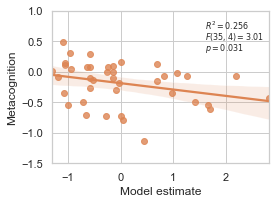

In [13]:
sns.set_context("paper")
sns.set(style="whitegrid")
plt.figure(figsize=(4, 3))
g = sns.regplot(x=zscore(fep_stat[select_name[:-1]].values.sum(axis=1)), 
                y=select_name[-1], 
                data=fep_stat,
                color=sns.color_palette()[1])
g.set_ylim(-1.5, 1)
g.set_xlabel("Model estimate")
g.set_ylabel("Metacognition")
g.annotate(r"$R^{2}=0.256$", (1.6, 0.7), fontsize=8)
g.annotate(r"$F(35, 4)=3.01$", (1.6, 0.525), fontsize=8)
g.annotate(r"$p=0.031$", (1.6, 0.35), fontsize=8)
g.annotate(r"$* Metacognition = log(\frac{awareness_{Heart}} {awareness_{Note}})$",
           (0.2, -1.6), fontsize=8)
plt.tight_layout()
plt.savefig("figures/metacog_CDStrait_model.png", dpi=300)

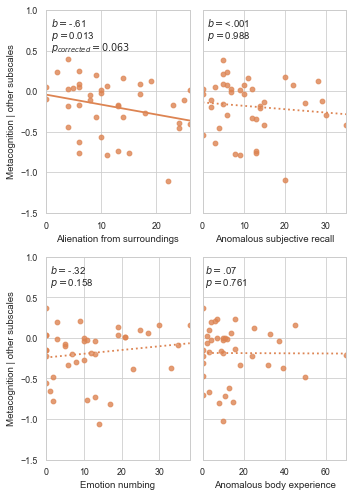

In [14]:
sns.set_context("paper")
i = 0
fig, axes = plt.subplots(2, 2, figsize=(5, 7))
for x, stats in zip(select_name[:-1], 
                    [("-.61", "0.013"),
                     ("<.001", "0.988"),
                     ("-.32", "0.158"),
                     (".07", "0.761")
                    ]):
    ci = False 
    partial = [i for i in select_name[:-1] if i != x]
    if x == "Alienation from surroundings":
        ci = True
    g = sns.regplot(x=x, y=select_name[-1], data=fep_stat, 
                    y_partial=zscore(fep_stat[partial].values.sum(axis=1)),
                    fit_reg=True, ax=axes[int(i/2), np.mod(i, 2)],
                    color=sns.color_palette()[1], ci=ci
                   )
    if x != "Alienation from surroundings":
        g.lines[0].set_linestyle(":")
    g.set_ylim(-1.5, 1)
    g.set_xlim(0, fep_stat[x].max())
    if np.mod(i, 2) == 0:
        g.set_ylabel("Metacognition | other subscales")
    else:
        g.set_ylabel("")
        g.set(yticklabels=[])
        
    g.annotate(r"$b=$" + stats[0], (1, 0.8))
    g.annotate(r"$p=$" + stats[1], (1, 0.65))
    if i ==0:
        g.annotate(r"$p_{corrected}=0.063$", (1, 0.5))
    
    i += 1

plt.tight_layout()
plt.savefig(f"figures/metacog_CDStrait_subscale.png", dpi=300)

## Behavioural

/home/hw1012/projects/critchley_depersonalisation/env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/hw1012/projects/critchley_depersonalisation/env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/hw1012/projects/critchley_depersonalisation/env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

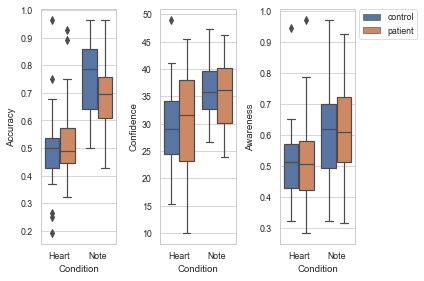

In [15]:
fig, ax =  plt.subplots(1, 3)
i = 0
for s, measure in zip(["Acc", "Sensib", "Aware"], ["Accuracy", "Confidence", "Awareness"]):
    plot_data = full_sample[[f"Heart{s}", f"Note{s}", "group"]]
    plot_data["participant_id"] = plot_data.index
    plot_data = plot_data.melt(id_vars=["participant_id", "group"])
    plot_data.columns = ["participant_id", "Group", "Condition", measure]
    plot_data = plot_data.replace(f"Heart{s}", "Heart")
    plot_data = plot_data.replace(f"Note{s}", "Note")
    g = sns.boxplot(x="Condition", y=measure, hue="Group", 
                    data=plot_data, ax=ax[i])
    if i < 2:
        g.legend_.remove()
    else: 
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    i += 1
plt.tight_layout()
plt.savefig("figures/task_performance.png", dpi=300)

In [16]:
from scipy.stats import ttest_1samp

tstat, pval= ttest_1samp(full_sample["HeartAcc"][full_sample["group"]=="control"], 0.5)
print(f"HeartAcc control : t = {tstat}, p = {pval}")
tstat, pval= ttest_1samp(full_sample["HeartAcc"][full_sample["group"]=="patient"], 0.5)
print(f"HeartAcc patient: t = {tstat}, p = {pval}")

tstat, pval= ttest_1samp(full_sample["HeartSensib"][full_sample["group"]=="control"], 25)
print(f"HeartSensib control : t = {tstat}, p = {pval}")
tstat, pval= ttest_1samp(full_sample["HeartSensib"][full_sample["group"]=="patient"], 25)
print(f"HeartSensib patient: t = {tstat}, p = {pval}")


tstat, pval= ttest_1samp(full_sample["HeartAware"][full_sample["group"]=="control"], 0.50)
print(f"HeartAware control : t = {tstat}, p = {pval}")
tstat, pval= ttest_1samp(full_sample["HeartAware"][full_sample["group"]=="patient"], 0.50)
print(f"HeartAware patient: t = {tstat}, p = {pval}")

HeartAcc control : t = -0.12990722964288376, p = 0.8979375001914836
HeartAcc patient: t = 0.8927051431121203, p = 0.3774905335929277
HeartSensib control : t = 2.118454940161163, p = 0.04685258086652851
HeartSensib patient: t = 3.2774985783211124, p = 0.002205849414743203
HeartAware control : t = 0.34567832863661124, p = 0.7331939907131697
HeartAware patient: t = 0.5828189584595505, p = 0.5633701318637583


## Introception > extroception

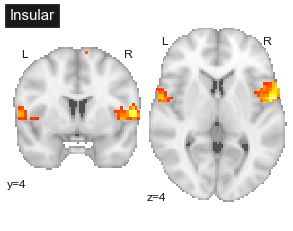

In [17]:
sig_tstat = "FSL_task/heart_wrt_note_thresh_tstat.nii.gz"

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plotting.plot_stat_map(sig_tstat,  title="Insular",
                       display_mode="yz",
                       cut_coords=(4, 4),
                       draw_cross=False, colorbar=False,
                       axes=ax
                      )
plt.savefig("figures/insular.png", dpi=300)

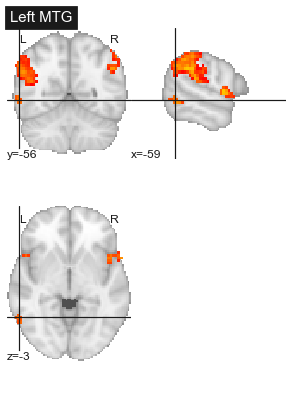

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(5, 7))
plotting.plot_stat_map(sig_tstat, title="Left MTG",
                       display_mode="tiled",
                       cut_coords=(-59, -56, -3),
                       draw_cross=True, colorbar=False,
                       axes=ax
                      )
plt.savefig("figures/LMTG.png", dpi=300)

In [20]:
stats = pd.concat([full_sample, hrv, copes_task], axis=1, join="inner")
stats["HeartNoteAware_bias"] = np.log(stats["HeartAware"] / stats["NoteAware"])
stats = stats[['insular_L', 'insular_R', 'MTG_L', "CDS_State", "HeartNoteAware_bias", "RMSSD"]]

In [21]:
for x in ['insular_L', 'insular_R', 'MTG_L']:
    for y in ["CDS_State", "HeartNoteAware_bias", "RMSSD"]:
        mod = smf.ols(formula=f'{y} ~ {x} ', data=stats.apply(zscore))
        res = mod.fit()
        print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              CDS_State   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     5.825
Date:                Wed, 06 May 2020   Prob (F-statistic):             0.0198
Time:                        16:29:14   Log-Likelihood:                -66.666
No. Observations:                  49   AIC:                             137.3
Df Residuals:                      47   BIC:                             141.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.684e-17      0.138    3.4e-16      1.0

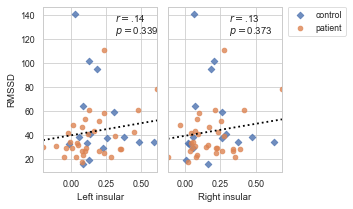

In [22]:
stats = pd.concat([full_sample, hrv, copes_task], axis=1, join="inner")
stats["HeartNoteAware_bias"] = np.log(stats["HeartAware"] / stats["NoteAware"])
select_name = ["Left insular", "Right insular","RMSSD","Group"]
select_var = ["insular_L", "insular_R", 
              "RMSSD", "group"]

data = stats[select_var]
data.columns = select_name

fig, axes = plt.subplots(1, 2, figsize=(5, 3))

for (i, region), stats in zip(enumerate(["Left insular", "Right insular"]),
                              [(".14", "0.339"),
                               (".13", "0.373")]):
    
    axes[i].scatter(data[data["Group"] == "control"][region], 
                 data[data["Group"] == "control"]["RMSSD"], 
                 label="control", marker="D", alpha=0.8)
    axes[i].scatter(data[data["Group"] == "patient"][region], 
                 data[data["Group"] == "patient"]["RMSSD"],
                 label="patient", marker="o", alpha=0.8)
    
    g = sns.regplot(region, "RMSSD", data=data, ax=axes[i], 
                fit_reg=True, scatter=False, ci=None, color="black")
    g.lines[0].set_linestyle(":")
    if i == 1:
        axes[i].set_ylabel("")
        axes[i].set(yticklabels=[])
    g.annotate(r"$r=$" + stats[0], (0.31, 135))
    g.annotate(r"$p=$" + stats[1], (0.31, 125))
        
        
axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig("figures/insular_vs_rmssd.png", dpi=300)

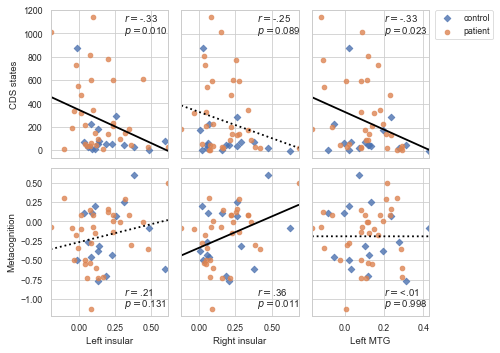

In [23]:
select_name = ["Left insular", "Right insular", "Left MTG",
               "CDS states", "Metacognition","Group"
              ]
select_var = ["insular_L", "insular_R", "MTG_L",
              "CDS_State", "HeartNoteAware_bias", "group"]

stats = pd.concat([full_sample, hrv, copes_task], axis=1, join="inner")
stats["HeartNoteAware_bias"] = np.log(stats["HeartAware"] / stats["NoteAware"])
stats = stats[select_var]

data = stats[select_var]
data.columns = select_name

fig, axes = plt.subplots(2, 3, figsize=(7, 5))
stats = [[("-.33", "0.010"), ("-.25", "0.089"), ("-.33", "0.023")], 
         [(".21", "0.131"), (".36", "0.011"), ("<.01", "0.998")]]

for j, region in enumerate(["Left insular", "Right insular", "Left MTG"]):
    for i, measure in enumerate(["CDS states", "Metacognition"]):
        axes[i, j].scatter(data[data["Group"] == "control"][region], 
                     data[data["Group"] == "control"][measure], 
                     label="control", marker="D", alpha=0.8)
        axes[i, j].scatter(data[data["Group"] == "patient"][region], 
                     data[data["Group"] == "patient"][measure],
                     label="patient", marker="o", alpha=0.8)
    
        g = sns.regplot(region, measure, data=data, 
                        fit_reg=True, scatter=False, ci=None, 
                        ax=axes[i, j], color="black")
        
        if j != 0:
            axes[i, j].set_ylabel("")
            axes[i, j].set(yticklabels=[])

        if i == 0:
            axes[i, j].set_xlabel("")
            axes[i, j].set(xticklabels=[])
        if ((measure == "CDS states" and region in ["Left insular", "Left MTG"]) or
            (measure == "Metacognition" and region == "Right insular")):
            g.lines[0].set_linestyle("-")
        else:
            g.lines[0].set_linestyle(":")
        
        if region =="Left insular":
            x = 0.31
        elif region =="Right insular":
            x = 0.4
        else:
            x = 0.2
        if measure == "CDS states":
            y1, y2 = 1100, 1000
        else:
            y1, y2 = -0.95, -1.1
            
        g.annotate(r"$r=$" + stats[i][j][0], (x, y1))
        g.annotate(r"$p=$" + stats[i][j][1], (x, y2))
            
axes[0, 2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

plt.savefig("figures/copes_vs_beh_scatter_original.png", dpi=300)

In [24]:
fep_stat = ["AlienSurroundTot", "AnomSubRecTot", "EmoNumTot", "AnomBodyExpTot", "MTG_L"]
stats = pd.concat([full_sample, copes_task], axis=1, join="inner")
fep_stat = stats[fep_stat][stats["group"] == "patient"]

mod = smf.ols(formula=f'MTG_L ~ AlienSurroundTot + AnomSubRecTot + EmoNumTot + AnomBodyExpTot', 
              data=fep_stat.apply(zscore))
res = mod.fit()
print(res.summary())
reject, p_corrected, _, alphaBonf = multipletests(res.pvalues, is_sorted=False)
corrected_p = pd.DataFrame(res.pvalues.values, index=res.pvalues.index, columns=["uncorrected"])
corrected_p["corrected"] = p_corrected
corrected_p

                            OLS Regression Results                            
Dep. Variable:                  MTG_L   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.9660
Date:                Wed, 06 May 2020   Prob (F-statistic):              0.442
Time:                        16:29:52   Log-Likelihood:                -44.692
No. Observations:                  33   AIC:                             99.38
Df Residuals:                      28   BIC:                             106.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -1.388e-17      0.177  

,uncorrected,corrected
Intercept,1.000000,1.000000
AlienSurroundTot,0.414600,0.799387
AnomSubRecTot,0.209116,0.690569
EmoNumTot,0.267522,0.712142
AnomBodyExpTot,0.763823,0.944220


In [25]:
stats = pd.concat([full_sample, hrv, copes_hrv], axis=1, join="inner")
stats["HeartNoteAware_bias"] = np.log(stats["HeartAware"] / stats["NoteAware"])
stats = stats[['insular_L', 'insular_R', "CDS_State", "HeartNoteAware_bias", "RMSSD"]]

for x in ['insular_L', 'insular_R']:
    for y in ["CDS_State", "HeartNoteAware_bias", "RMSSD"]:
        mod = smf.ols(formula=f'{y} ~ {x}', 
                      data=stats.apply(zscore))
        res = mod.fit()
        print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              CDS_State   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.7584
Date:                Wed, 06 May 2020   Prob (F-statistic):              0.388
Time:                        16:32:17   Log-Likelihood:                -69.136
No. Observations:                  49   AIC:                             142.3
Df Residuals:                      47   BIC:                             146.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.684e-17      0.145   3.24e-16      1.0

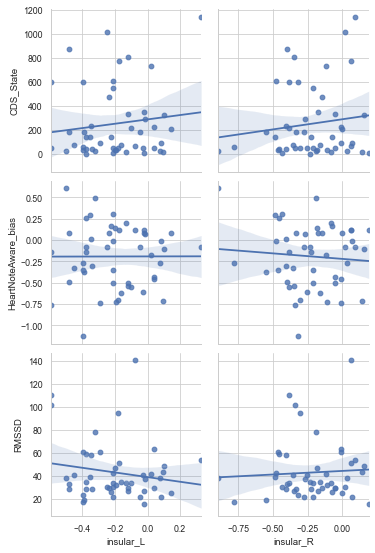

In [31]:
sns.pairplot(x_vars=["insular_L", "insular_R"], 
             y_vars=["CDS_State", "HeartNoteAware_bias", "RMSSD"], 
             data=stats, kind="reg")

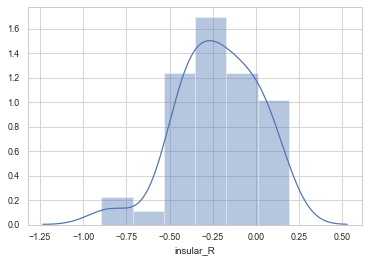

In [29]:
sns.distplot(stats["insular_R"])